In [75]:
import pandas as pd
df = pd.read_csv("Data.csv")

In [76]:
df['X'] = df['X'].apply(lambda X:sum(map(int, X.split('-')))/2)
print(df.describe())

                  X          Y          E
count     37.000000  37.000000  37.000000
mean    3271.081081   1.755081   0.289676
std     4805.451130   1.205085   0.250918
min       14.000000  -0.223000   0.120000
25%      120.500000   0.913000   0.130000
50%      979.000000   1.856000   0.179000
75%     4256.500000   2.334000   0.290000
max    18494.000000   4.435000   1.030000


In [77]:
E = df['X']
t = df['Y']
err = df['E']

In [78]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

<IPython.core.display.Javascript object>


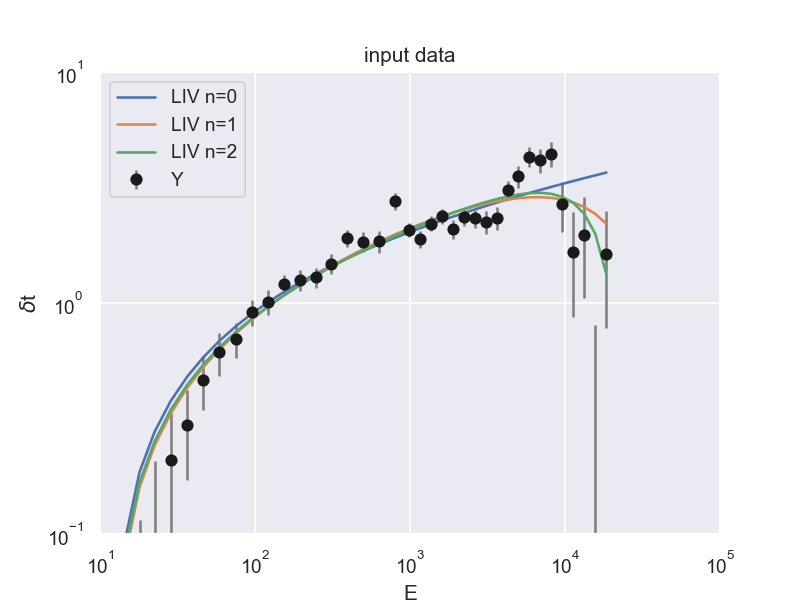

In [79]:
fr = plt.figure

axis = plt.subplot(xscale='log', yscale='log', xlim=(10, 1e5), ylim=(0.1,10))
axis.errorbar(E, t, err, fmt='ok', ecolor='grey')
axis.set(xlabel='E', ylabel='$\delta$t', title='input data',);

In [80]:
from numpy import exp
import functools
import scipy.integrate as integral
chisq = []
def model(E, tau, alpha, Eqg, deg):
    f = lambda z: (1+z)**deg/((0.685+0.315*(1+z)**3)**0.5)
    i, unc = integral.quad(f, 0, 1.406)
    if(deg==0):
        return tau*(E**alpha - 11.34**alpha)
    else:
        return tau*(E**alpha - 11.34**alpha) - (1+deg)*(E**deg - 11.34**deg)*i/(2*67.3*(Eqg**deg))
    
def fncnal(deg_i):
    if (deg_i==0):
        return functools.partial(model,Eqg=2,deg=deg_i)
    return functools.partial(model,deg=deg_i)

In [81]:
def calc_AIC(chi, p, N=37):
    aic = chi + 2*p + 2*p*(p+1)/(N-p-1)
    return aic

def calc_BIC(chi, p, N=37):
    bic = chi + p*np.log(N)
    return bic

In [82]:
import scipy.optimize as opt
import numpy as np
AIC, BIC = [], []

for temp in range(3):
    model_neo = fncnal(temp)
    if (temp==0):
        init_theta = np.random.uniform(0, 1, 2)
    else:
        init_theta = np.random.uniform(0, 1, 3)
    ans, cov = opt.curve_fit(model_neo, xdata=E, ydata=t, sigma=err, p0=init_theta, absolute_sigma=True)
    
    if (temp==0):
        tau_fit, alpha_fit = ans
    else:
        tau_fit, alpha_fit, Eqg_fit = ans
    
    if (temp==0):
        best_fit = model_neo(E, tau_fit, alpha_fit)
    else:
        best_fit = model_neo(E, tau_fit, alpha_fit, Eqg_fit)
    axis.plot(E, best_fit, label='LIV n='+str(temp))
    axis.legend()
    residual = (t - best_fit)/err
    chisq.append(np.sum(residual**2))
    AIC.append(calc_AIC(chisq[temp], 2+(temp!=0)))
    BIC.append(calc_BIC(chisq[temp], 2+(temp!=0)))

In [83]:
chisq = np.asarray(chisq)
chisq_DOF = chisq/[35, 34, 34]

#calculating p-value
from scipy import stats

            #for LIV n=1                             #for LIV n=2
p = [1-stats.chi2.cdf(chisq[0]-chisq[1], 1), 1-stats.chi2.cdf(chisq[0]-chisq[2], 1)]

print (p)

[0.0011430647160591834, 9.196850294845849e-05]


In [84]:
#computing Akaike and Bayesian Information Criterion

delta_AIC = [AIC[0]-AIC[1], AIC[0]-AIC[2]]
delta_BIC = [BIC[0]-BIC[1], BIC[0]-BIC[2]]
print (delta_AIC)
print (delta_BIC)

[8.205849387109453, 12.920485523619746]
[6.969263025267367, 11.68389916177766]
